In [1]:
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target

# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样
# 使用相同的seed，保证输入特征和标签一一对应
np.random.seed(116)
# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# 多维矩阵中，只对第一维（行）做打乱顺序操作
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)

In [3]:
# 将打乱后的数据集分割为训练集与测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

x_train = tf.cast(x_train,tf.float32)
x_test = tf.cast(x_test,tf.float32)

In [4]:
# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch_size=32）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [5]:
# 生成神经网络的参数，4个输入特征，输入层为4个节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（实践时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

In [6]:
lr = 0.1#学习率
train_loss_result = []#记录每轮训练之后的loss
test_acc = []#模型准确度
epochs = 300#训练轮数
loss_all = 0#每轮分为4step，记录四个step生成的4个loss和

In [7]:
# 测试部分
def test():
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.nn.softmax(y)
        # 返回y中(行)最大值的索引，即预测的分类
        pred = tf.argmax(y, axis=1)
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool类型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc：", acc)
    print("-------------------")
    return acc

In [8]:
# 训练部分
# 数据集级别的循环，每个epoch循环一次数据集
for epoch in range(epochs):
    # batch级别的循环，每个step循环一个batch
    for step, (x_train, y_train) in enumerate(train_db):
        # with结构记录梯度的信息
        with tf.GradientTape() as tape:
            # 神经网络乘加运算
            y = tf.matmul(x_train, w1) + b1
            # 使得输出y符合概率分布（此操作后与独热码同量级，可相减后求loss）
            y = tf.nn.softmax(y)
            # 将标签值转换为独热编码格式，方便计算loss和accuracy
            y0 = tf.one_hot(y_train, depth=3)
            # 采用均方误差损失函数 mse=mean(sum(y0 - y)^2)
            loss = tf.reduce_mean(tf.square(y0 - y))
            # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
            loss_all += loss.numpy()
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1])
        # 实现梯度更新 w1 = w1 - lr * w1_grad或b = b- lr * b1_grad
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])

    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all / 4))
    test()
    # 将4个step的loss求平均记录在此变量中
    train_loss_result.append(loss_all / 4)
    # loss_all归零，为记录下一个epoch的loss做准备
    loss_all = 0

Epoch 0, loss: 0.22554027661681175
Test_acc： 0.16666666666666666
-------------------
Epoch 1, loss: 0.21629425138235092
Test_acc： 0.16666666666666666
-------------------
Epoch 2, loss: 0.20693744719028473
Test_acc： 0.16666666666666666
-------------------
Epoch 3, loss: 0.19672195985913277
Test_acc： 0.16666666666666666
-------------------
Epoch 4, loss: 0.186280507594347
Test_acc： 0.5333333333333333
-------------------
Epoch 5, loss: 0.1762811355292797
Test_acc： 0.5333333333333333
-------------------
Epoch 6, loss: 0.1671784408390522
Test_acc： 0.5333333333333333
-------------------
Epoch 7, loss: 0.15916013345122337
Test_acc： 0.5333333333333333
-------------------
Epoch 8, loss: 0.15222227573394775
Test_acc： 0.5333333333333333
-------------------
Epoch 9, loss: 0.14626356214284897
Test_acc： 0.5333333333333333
-------------------
Epoch 10, loss: 0.1411493457853794
Test_acc： 0.5333333333333333
-------------------
Epoch 11, loss: 0.13674486242234707
Test_acc： 0.5333333333333333
-----------

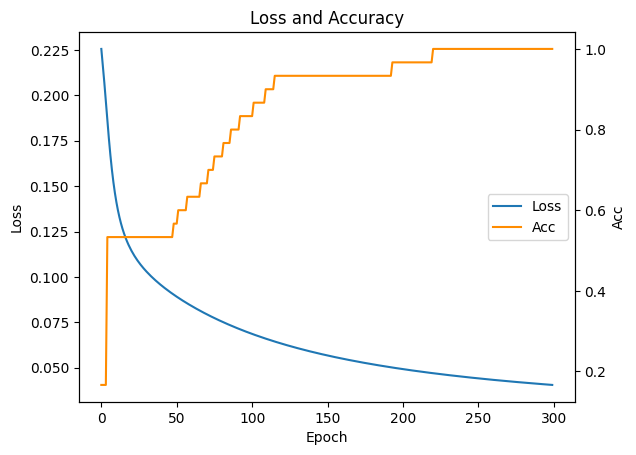

In [9]:
# 绘制loss曲线
# plt.title("Losss Function Curve")
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# l,=plt.plot(train_loss_result,label="$Loss$") # 逐点画出trian_loss_results值并连线，连线图标是Loss
# plt.legend()
# plt.savefig("./loss")
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
l, =ax1.plot(train_loss_result,label="$Loss$")
 
# 绘制Accuracy曲线
# plt.title("Acc Curve")
# plt.xlabel("Epoch")
# plt.ylabel("Acc")
# a,=plt.plot(test_acc,label="$Accuracy$") # 逐点画出test_acc值并连线，连线图标是Accuracy
# plt.legend()
# plt.savefig("./acc")
ax2 = ax1.twinx()  # this is the important function
ax2.set_title("Loss and Accuracy")
ax2.set_ylabel("Acc")
a, =ax2.plot(test_acc,'darkorange',label="$Accuracy$")

lines=[l,a]
labels=['Loss','Acc']
plt.legend(lines,labels,loc='center right')
plt.savefig("./imgs/ex_12_04_1")